<a href="https://colab.research.google.com/github/ntabanarachel/STT-engine/blob/dev_rachel/Speech_to_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#list Directory inside AMHARIC
import os
os.chdir("/content/drive/MyDrive/Week-4/speech_data/ALFFA_PUBLIC/ASR/AMHARIC")
os.listdir()

['data', 'README.md', 'kaldi-script', 'lang', 'lm']

In [ ]:
pip install augmentation


Data visualization and investigation


In [ ]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

1. Visualization
There are two theories of a human hearing - place (frequency-based) and temporal) In speech recognition, I see two main tendencies - to input spectrogram (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

Let's visualize some recordings!

1.1. Wave and spectrogram:
Choose and read some file:

In [ ]:
train_audio_path = '/content/drive/MyDrive/Week-4/speech_data/ALFFA_PUBLIC/ASR/AMHARIC/data/train'
filename = '/wav/tr_10000_tr097082.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Frequencies are in range (0, 8000) according to Niquist theorem.

Let's plot it:

Text(0.5, 0, 'Seconds')

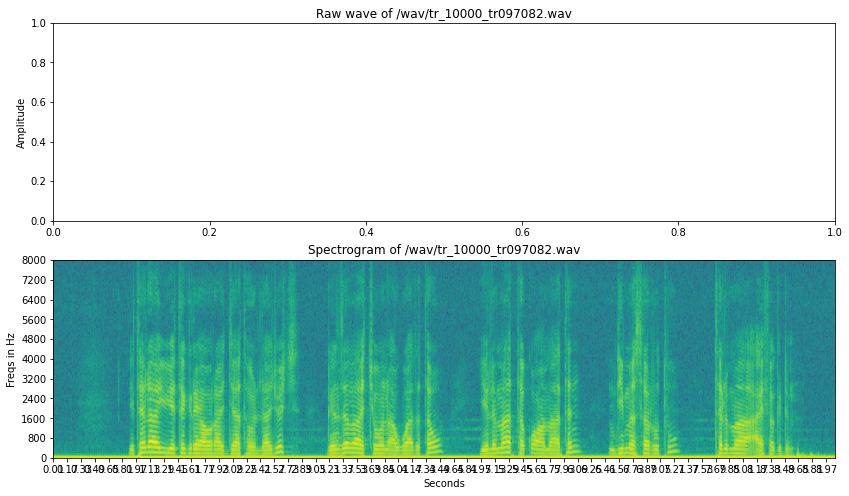

In [ ]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
#ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

If we use spectrogram as an input features for NN, we have to remember to normalize features. (We need to normalize over all the dataset, here's example just for one, which doesn't give good mean and std!)

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

1.3. MFCC

1.4. Features extraction steps
I would propose the feature extraction algorithm like that:

VAD
Maybe padding with 0 to make signals be equal length
Log spectrogram (or MFCC, or PLP)
Features normalization with mean and std
Stacking of a given number of frames to get temporal information
It's a pity it can't be done in notebook. It has not much sense to write things from zero, and everything is ready to take, but in packages, that can not be imported in Kernels.

2. Dataset investigation
Some usuall investgation of dataset.

2.1. Number of records

In [ ]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 1


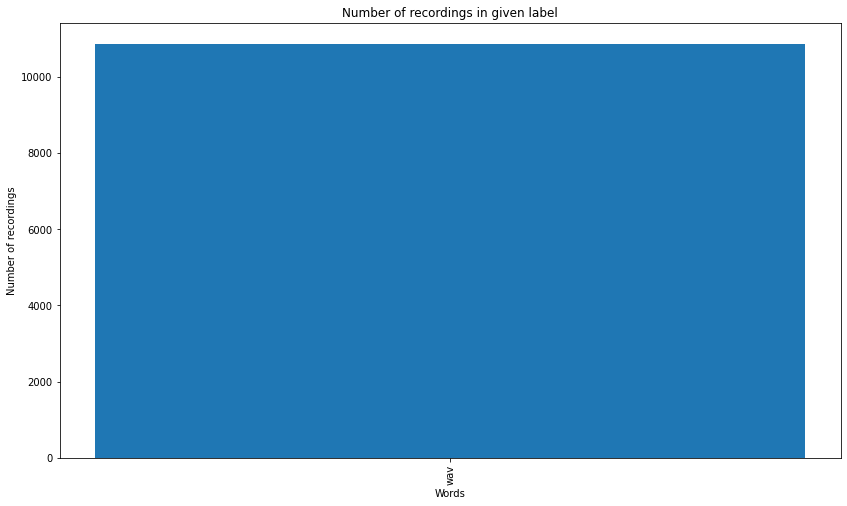

In [ ]:
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

plt.figure(figsize=(14,8))
plt.bar(dirs, number_of_recordings)
plt.title('Number of recordings in given label')
plt.xticks(rotation='vertical')
plt.ylabel('Number of recordings')
plt.xlabel('Words')
plt.show()

Dataset is balanced except of background_noise, but that's the different thing.

2.2. Deeper into recordings
We'll need to calculate FFT (Fast Fourier Transform). Definition:

In [ ]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

There are also recordings with some weird silence (some compression?):



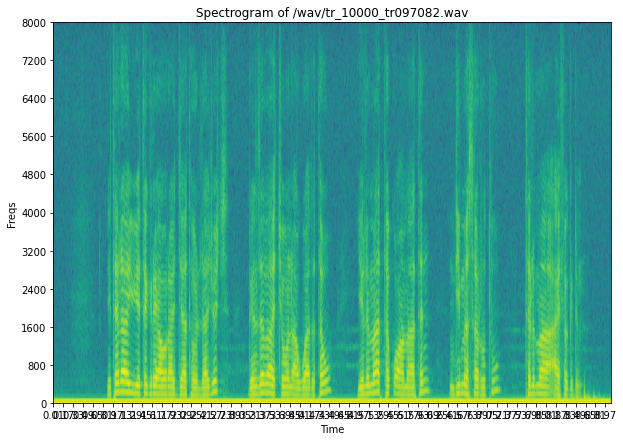

In [ ]:
filename = '/wav/tr_10000_tr097082.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()


Recordings length
Find if all the files have 1 second duration:



In [ ]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))


Number of recordings shorter than 1 second: 0


 Mean spectrograms and FFT

In [ ]:
to_keep = 'yes no up down left right on off stop go silence unknown'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)
        plt.figure(figsize=(14, 5))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()


[]


Audio Data Augmentation

In [ ]:
from subprocess import check_output


Data augmentation definition :
Data augmentation is the process by which we create new synthetic training samples by adding small perturbations on our initial training set.
The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
In order to this to work adding the perturbations must conserve the same label as the original training sample.
In images data augmention can be performed by shifting the image, zooming, rotating ...
In our case we will add noise, stretch and roll, pitch shift ...

In [ ]:
def load_audio_file(file_path):
    input_length = 44100*5
    data = librosa.core.load(file_path,sr=44100)[0] #, sr=16000
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
    return data
def plot_time_series(data):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 5, len(data)), data)
    plt.show()

In [ ]:
import librosa

In [ ]:
audio, rate=librosa.load(train_audio_path+ '/wav/tr_10000_tr097082.wav', sr=44100)

In [ ]:
ipd.Audio(samples, rate=sample_rate)

In [ ]:
def meta_data(trans, path ):
  target=[]
  features=[]
  filenames=[]
  duration_of_recordings=[]
  for k in trans:
    filename=path+k +".wav"
    filenames.append(filename)
    audio, fs = librosa.load(filename, sr=None)
    duration_of_recordings.append(float(len(audio)/fs))
   
    lable = trans[k]
    target.append(lable)
  return filenames, target,duration_of_recordings


In [ ]:
%matplotlib inline
import librosa.display

#Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(samples, sr=sample_rate)